In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

from matplotlib.lines import Line2D
from scipy.stats import bootstrap


In [3]:
from importlib import reload

from wombats import utils
from wombats import metrics
from wombats import models
from wombats import perturbations
import random
# if changes to the files run this to reload the moduls
utils = reload(utils)
metrics = reload(metrics)
models = reload(models)

In [4]:
data_file = Path('../data/steinmetz/steinmetz_all.npy')
data_folder = Path('../data/steinmetz/')
if not data_file.exists():
    data = utils.load_steinmentz()
    data_folder.mkdir(parents=True)
    data_file.touch()
    np.save(data_file, data)
else:
    data = np.load(data_file, allow_pickle=True)

In [5]:
def train_models(session_data, trials):
    stim, region1_data, region2_data, response = get_trial_data(session_data, trials)

    # train the model
    A1 = models.get_a1(stim, region1_data)
    A2 = models.get_a2(stim@A1, region2_data)  ## input is encoder output
    A3 = models.get_a3(region2_data, response)
    
    A = np.array([A1, A2, A3], dtype=object)
    return A


def get_fit_r2(in_data, fit_matrix, out_data):
    out_data_hat = (in_data@fit_matrix).T
    
    with np.errstate(divide='ignore', invalid='ignore'):
        r2 = metrics.r2(np.squeeze(out_data), out_data_hat)
        
    r2[~np.isfinite(r2)] = np.nan
    return np.nanmean(r2)

def get_trial_data(session_data, trials):
    stim = session_data['stim'][trials]
    region1_data = session_data['fr']['region1'][:, trials]
    region2_data = session_data['fr']['region2'][:, trials]
    response = session_data['response'][trials]
    response[response==0]=np.nan
    response[response>0]=1
    response[response<0]=0
    
    return stim, region1_data, region2_data, response    


def get_fit_performance_by_mat(session_data, A, trials):
    stim, region1_data, region2_data, response = get_trial_data(session_data, trials)
 
    R2 = np.zeros(3)
    R2[0] = get_fit_r2(stim, A[0], region1_data)
    R2[1] = get_fit_r2(stim@A[0], A[1], region2_data)
    
    decoder_out = np.squeeze(region2_data).T@A[2]
    R2[2] = metrics.binarry_acc(decoder_out>0, response)
    
    return R2


def add_cross_val_entry_fits(table, start_idx, fold_num, split, scores):
    
    idx = start_idx

    table.loc[idx:(idx+2), 'cross_val_fold'] = fold_num
    table.loc[idx:(idx+2), 'data_split'] = split
    for num in range(3):
        table.loc[idx, 'matrix'] = matrices[num]
        table.loc[idx, 'score'] = scores[num]
        idx+=1
    
    return table, idx
    
def get_full_model_perfomance(session_data, AE, trials):
    stim, region1_data, region2_data, subject_response = get_trial_data(session_data, trials)
    model_response = models.get_model_output(stim, AE=AE)
    
    correct_response = stim_2_labels(stim)
    
    out = np.zeros(3)
    out[0] = metrics.binarry_acc(correct_response, subject_response) # 'TvS'
    out[1] = metrics.binarry_acc(correct_response, model_response) # TvM
    out[2] = metrics.binarry_acc(subject_response, model_response) # SvM
    
    return out

def add_cross_val_entry_model_perf(table, start_idx, fold_num, pert_type, pert_pct, pert_matrix, split, scores):
    
    idx = start_idx
    
    table.loc[idx:(idx+2), 'cross_val_fold'] = fold_num
    table.loc[idx:(idx+2), 'data_split'] = split

    table.loc[idx:(idx+2), 'pert_type'] = pert_type
    table.loc[idx:(idx+2), 'pert_pct'] = pert_pct
    table.loc[idx:(idx+2), 'pert_matrix'] = pert_matrix
    
    for num in range(3):
        table.loc[idx, 'comparison'] = comparisons[num]
        table.loc[idx, 'score'] = scores[num]
        idx+=1
    
    return table, idx

def get_trial_types_idx(trials, trial_type):
    return np.where(trials==trial_type)[0]

def stim_2_labels(stims):
    stim_diff = np.diff(stims[:,1:],1).squeeze()
    stim_diff[stim_diff==0] = np.nan
    stim_diff[stim_diff>0] = 1
    stim_diff[stim_diff<0] = 0

    return stim_diff

## experiment parameters

In [164]:
utils = reload(utils)

# simulation parameters
time_windows = {0:[-0.5,-0], 1: [0, 0.5], 2: [0.5, 1]}
num_folds = 5
region1_list = ['visual', 'motor']
region2_list = ['motor', 'visual']
fit_data_splits = ['train', 'test']

data_split_types = ['train', 'test', 'nono', 'nogo', 'noresp']
comparisons = ['TvS', 'TvM', 'SvM']
pert_types = ['ablation']
pert_pcts = [0, 0.05, 0.1, 0.25, 0.5, 0.75]
matrices = ['A1', 'A2', 'A3' ]

# output matrix
perf_df_all = pd.DataFrame(columns=['region1', 'region2', 'session_num', 'time_bin', 'cross_val_fold', 'data_split', 'comparison', 'pert_type', 'pert_pct', 'pert_matrix', 'score'])

fit_perf_df_all = pd.DataFrame(columns=['region1', 'region2', 'session_num', 'time_bin', 'cross_val_fold', 'data_split', 'matrix', 'score'])



## run experiment

In [165]:
%%time 

perturbations = reload(perturbations)
utils = reload(utils)
metrics = reload(metrics)
models = reload(models)


for region1, region2 in zip(region1_list, region2_list):

    for time_bin in time_windows.keys():

        # data
        dataset = utils.DataSet(data, region1=region1, region2=region2, analysis_time_window=time_windows[time_bin])

        # pre-allocate outputs
        n_sessions = dataset.n_valid_sessions


        n_rows = n_sessions * num_folds * len(data_split_types) * len(comparisons) * len(pert_types) * len(pert_pcts) * len(matrices)
        perf_df = pd.DataFrame(index=range(n_rows), columns=['region1', 'region2', 'session_num', 
                                                             'time_bin', 'cross_val_fold', 'data_split', 
                                                             'comparison', 'pert_type', 'pert_pct', 'pert_matrix', 'score'])

        n_core_perf_rows = num_folds * len(data_split_types) * len(matrices)*len(pert_pcts)*len(pert_types)*len(comparisons)
        perf_df['session_num'] = np.repeat(np.arange(n_sessions), n_core_perf_rows)
        perf_df['region1'] = region1
        perf_df['region2'] = region2
        perf_df['time_bin'] = time_bin


        n_rows = n_sessions * num_folds * len(fit_data_splits) * len(matrices)
        fit_perf_df = pd.DataFrame(index=range(n_rows), columns=['region1', 'region2', 'session_num', 
                                                                 'time_bin', 'cross_val_fold', 'data_split', 'matrix', 'score'])

        n_core_fit_rows = num_folds * len(fit_data_splits) * len(matrices)
        fit_perf_df['session_num'] = np.repeat(np.arange(n_sessions), n_core_fit_rows)
        fit_perf_df['region1'] = region1
        fit_perf_df['region2'] = region2
        fit_perf_df['time_bin'] = time_bin


        for session_num in range(n_sessions):

            # initiate fit table for session
            session_fit_columns = ['cross_val_fold', 'data_split', 'matrix', 'score']
            n_rows = num_folds * len(fit_data_splits) * len(matrices)
            fit_perf_df_session = pd.DataFrame(index=range(n_rows), columns=session_fit_columns)
            fit_row_counter = 0


            # initiate model_perf table for session
            session_perf_columns = ['cross_val_fold', 'data_split','comparison', 'pert_matrix', 'pert_type', 'pert_pct', 'score']
            n_rows = num_folds * len(data_split_types) * len(matrices)*len(pert_pcts)*len(pert_types)*len(comparisons)
            perf_df_session = pd.DataFrame(index=range(n_rows), columns=session_perf_columns)
            perf_row_counter = 0

            session_data = dataset.data[session_num]

            trials = {}
            for trial_type in ['nogo', 'noresp', 'nono']:
                trials[trial_type] = get_trial_types_idx(session_data['trial_types'], trial_type)


            # get folds splis for valid trials
            cross_val_trials =  get_trial_types_idx(session_data['trial_types'], 'valid')
            stim, _, _, _ = get_trial_data(session_data, cross_val_trials)
            stim_label = stim_2_labels(stim)


            kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=session_num)
            fold_num =0
            for train_index, test_index in kf.split(cross_val_trials, stim_label):

                trials['train'] = cross_val_trials[train_index] 
                trials['test'] = cross_val_trials[test_index]

                A = train_models(session_data, trials['train'])

                for split in ['train', 'test']:
                    split_perf = get_fit_performance_by_mat(session_data, A, trials[split])
                    fit_perf_df_session, fit_row_counter = add_cross_val_entry_fits(table=fit_perf_df_session,
                                                                                    start_idx=fit_row_counter,
                                                                                    fold_num=fold_num,
                                                                                    split=split,
                                                                                    scores=split_perf)    
                for pert_type in pert_types:
                    for idx, pert_matrix in enumerate(matrices):
                        for pert_pct in pert_pcts:
                            A_p = np.copy(A)
                            if pert_pct!=0:
                                A_p[idx], _ = perturbations.pert_connections(connection_mat = A[idx], 
                                                                             pert_pct=pert_pct,
                                                                             pert_type=pert_type)
                            AE_p = models.get_ae(A_p)
                            for split in ['train', 'test', 'nogo', 'noresp', 'nono']:
                                split_perf = get_full_model_perfomance(session_data, AE_p, trials[split])

                                perf_df_session, perf_row_counter = add_cross_val_entry_model_perf(table=perf_df_session,
                                                                                                  start_idx=perf_row_counter,
                                                                                                  fold_num=fold_num,
                                                                                                  pert_type=pert_type,
                                                                                                  pert_pct=pert_pct,
                                                                                                  pert_matrix=pert_matrix,
                                                                                                  split=split,
                                                                                                  scores=split_perf)


                fold_num+=1

            perf_df.loc[perf_df.session_num==session_num, session_perf_columns] = perf_df_session.values
            fit_perf_df.loc[fit_perf_df.session_num==session_num, session_fit_columns] = fit_perf_df_session.values


        perf_df_all = pd.concat((perf_df_all, perf_df))
        fit_perf_df_all = pd.concat((fit_perf_df_all, fit_perf_df))
    
perf_df_all=perf_df_all.astype({'score': 'float'})
perf_df_all=perf_df_all.astype({'pert_pct': 'float'})    

CPU times: user 6min 38s, sys: 6.27 s, total: 6min 44s
Wall time: 40.6 s


In [167]:
perf_df_all

,region1,region2,session_num,time_bin,cross_val_fold,data_split,comparison,pert_type,pert_pct,pert_matrix,score
0,visual,motor,0,0,0,train,TvS,ablation,0.00,A1,0.893617
1,visual,motor,0,0,0,train,TvM,ablation,0.00,A1,1.000000
2,visual,motor,0,0,0,train,SvM,ablation,0.00,A1,0.893617
3,visual,motor,0,0,0,test,TvS,ablation,0.00,A1,0.791667
4,visual,motor,0,0,0,test,TvM,ablation,0.00,A1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
18895,motor,visual,13,2,4,noresp,TvM,ablation,0.75,A3,0.791667
18896,motor,visual,13,2,4,noresp,SvM,ablation,0.75,A3,0.000000
18897,motor,visual,13,2,4,nono,TvS,ablation,0.75,A3,0.000000
18898,motor,visual,13,2,4,nono,TvM,ablation,0.75,A3,0.000000


## paper figure

In [184]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

figures_path = Path("../img").resolve()

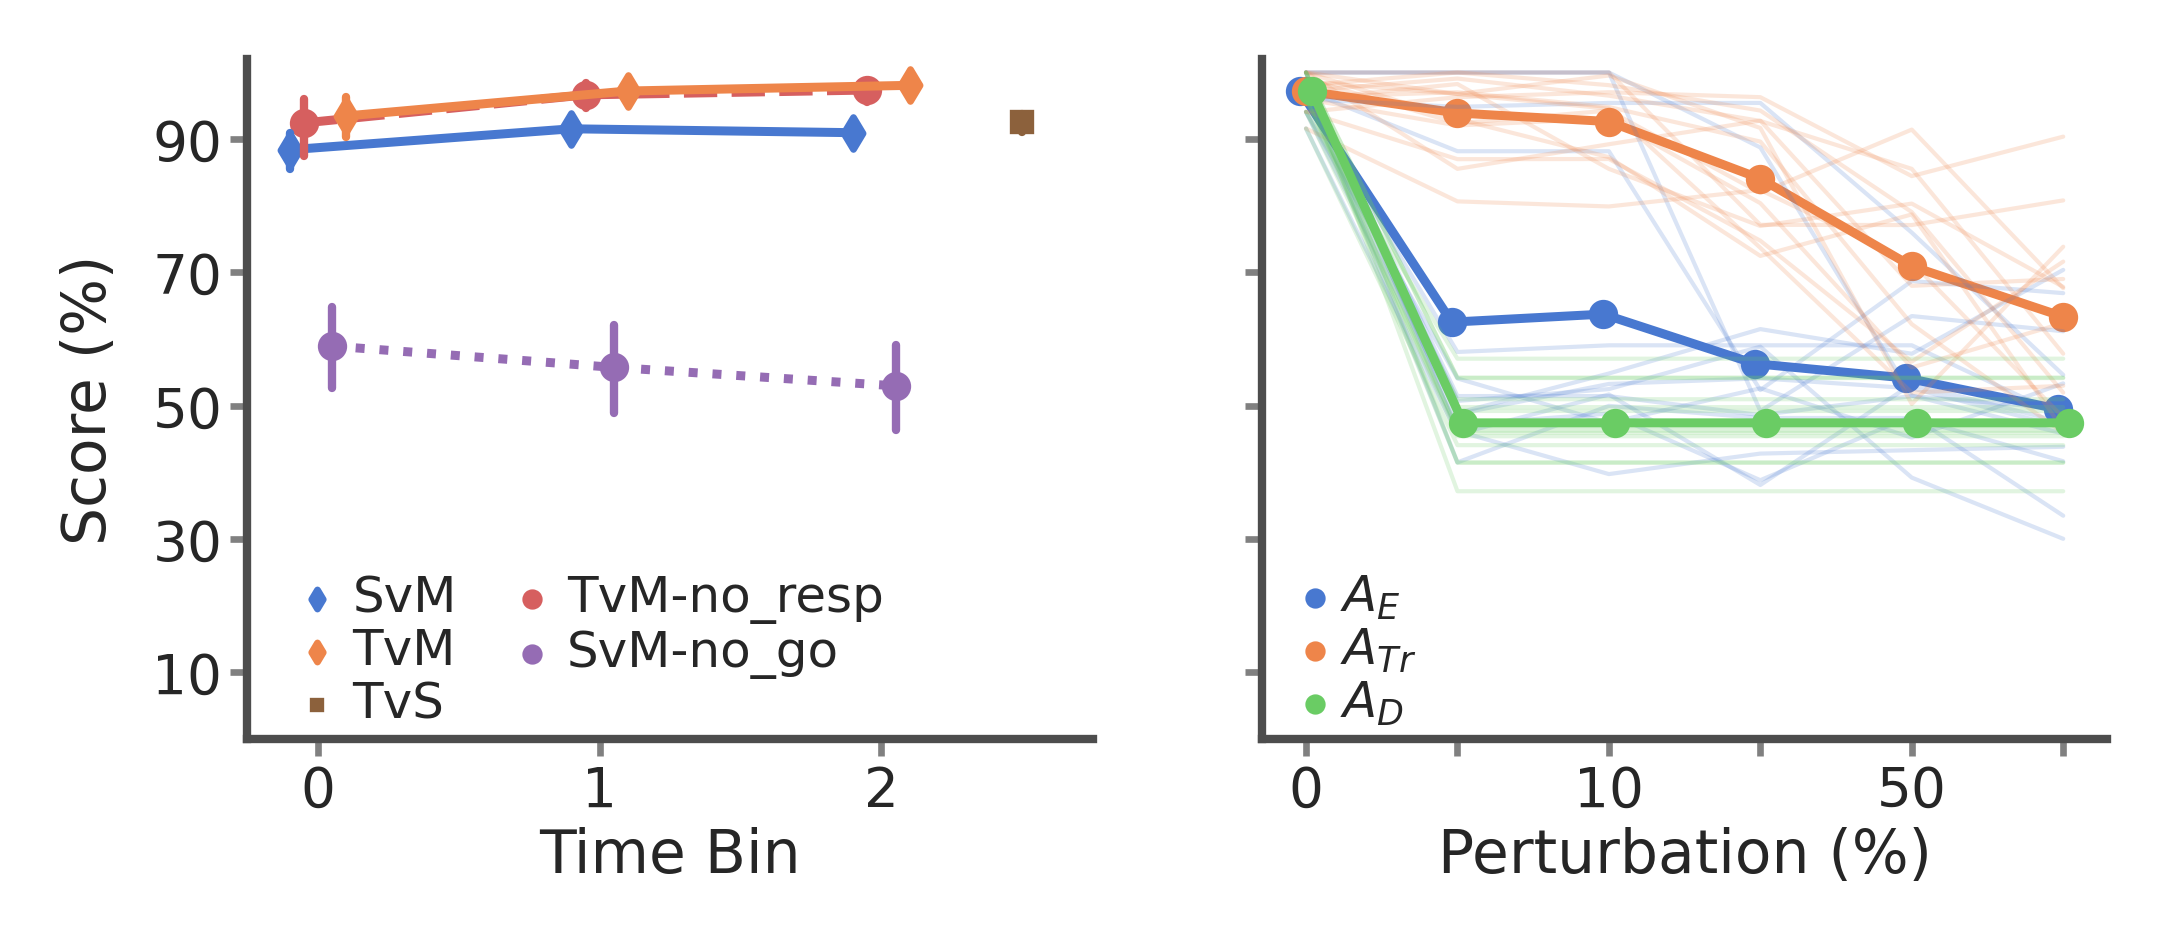

In [203]:
sns.set_theme(context='paper', style="white", font_scale=0.75, palette="Set2")
sns.set_style(rc={"axes.edgecolor":'0.3',
                 'xtick.bottom': True,
                 'ytick.left': True})

point_scale = 0.5
session_lw = 0.5
session_eb = 1
legend_font = 6

f,axes=plt.subplots(1,2, figsize=(4,1.5), dpi=600)

ax=axes[0]


split_order = ['test', 'nogo', 'noresp']
comparison_select = ['SvM', 'TvM']
region1 = 'motor'
region2 = 'visual'

subset = perf_df_all[(perf_df_all.pert_matrix=='A1') & 
                     (perf_df_all.pert_pct==0) & 
                     (perf_df_all.data_split.isin(split_order)) & 
                     (perf_df_all.comparison.isin(comparison_select)) & 
                     (perf_df_all.region1==region1) &
                     (perf_df_all.region2==region2)]

subset = subset.groupby(["session_num", "comparison", "data_split", "time_bin"], dropna=True).mean()
subset = subset.drop(['pert_pct'],axis=1)
subset = subset.reset_index()
subset = subset.copy()

subset.loc[ (subset.data_split=='nogo') & (subset.comparison.isin(['TvM', 'TvS'])) ] = np.nan
subset.loc[ (subset.data_split=='noresp') & (subset.comparison.isin(['SvM', 'TvS'])) ] = np.nan
subset = subset.dropna()

#####
sns.set_palette("muted")
colors = sns.color_palette()
sns.pointplot(x='time_bin', y='score', hue='comparison',  data=subset[subset.data_split=='test'], err_style='bars', ax=ax, 
              dodge=0.2, alpha=0.8, legend=True, scale=point_scale, errwidth=session_eb, capsize=0, markers=['d', 'd'], palette=colors[:2])


#####
split_order = ['test']
comparison_select = ['TvS']

subset2 =perf_df_all[(perf_df_all.pert_matrix=='A1') & 
                     (perf_df_all.pert_pct==0) & 
                     (perf_df_all.data_split.isin(split_order)) & 
                     (perf_df_all.comparison.isin(comparison_select)) & 
                     (perf_df_all.region1==region1) &
                     (perf_df_all.region2==region2)]
subset2 = subset2.groupby('session_num').mean()
r  = bootstrap( (subset2.score.values,), np.mean, confidence_level=0.95)

s_loc = 2.5
ax.scatter(s_loc, subset2.score.mean(), color=colors[5], s=point_scale*20, edgecolor='w', linewidth=0.2, label = 'TvS', marker='s')
ax.plot( (s_loc,s_loc), (r.confidence_interval.low, r.confidence_interval.high), color=colors[5], linewidth=session_eb)


sns.pointplot(x='time_bin', y='score', hue='comparison',  data=subset[subset.data_split!='test'], err_style='bars', ax=ax, 
              dodge=0.1, alpha=0.8, legend=True, scale=point_scale, errwidth=session_eb, capsize=0, linestyles=["--", ":"], palette=colors[3:], hue_order=['TvM', 'SvM'])

######
h,l = ax.get_legend_handles_labels()
l2 = l.copy()
l2[2] = 'TvS'
l2[3] = 'TvM-no_resp'
l2[4] = 'SvM-no_go'

ax.legend(h,l2, bbox_to_anchor=(0, -0.05), handlelength = 1, handletextpad=0.2, loc='lower left', 
          frameon=False, fontsize=legend_font, markerscale=0.6, ncol=2, columnspacing=1, labelspacing=0.1)

######
ax.set_ylim([0,1.02])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9])
ax.set_yticklabels([10, 30 , 50 , 70, 90])
ax.set_ylabel(f"Score (%)")

ax.set_xlim([-0.25, s_loc+0.25])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['0', '1', '2',])
ax.set_xlabel("Time Bin", labelpad=1)

ax.tick_params(axis='both', which='major', pad=-0.2)

#ax.set_title("Model Performance")

for ax in axes:
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    ax.tick_params(axis="both", direction="out", length=2, width=0.8, color="0.5",  which='major', pad=1)

###########----------------------###########
ax=axes[1]

time_bin = 1
comp = 'TvM'
split='test'

y_axis_label = {'TvM': "True v Model", "SvM": "Subject v Model" }

subset = perf_df_all[(perf_df_all.data_split==split) & 
                     (perf_df_all.comparison==comp) & 
                     (perf_df_all.time_bin==time_bin) &
                     (perf_df_all.region1==region1) &
                     (perf_df_all.region2==region2)]
subset = subset.groupby(["session_num", "pert_pct", "pert_matrix"]).mean()
subset = subset.reset_index()
subset = subset.astype({'pert_pct': str})

ax = sns.pointplot(x='pert_pct', y='score', hue='pert_matrix', data=subset, ci=None, legend=False, dodge=True, ax=ax, scale=point_scale)
sns.lineplot(x='pert_pct', y='score', hue='pert_matrix', units='session_num', estimator=None, data=subset, alpha=0.2, ax=ax, legend=False, linewidth=session_lw)

ax.set_ylim([0,1.02])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9])
ax.set_yticklabels([])
ax.set_ylabel('')

h,l = ax.get_legend_handles_labels()
ax.legend(h, [r'$A_E$', r'$A_{Tr}$', r'$A_D$'] , bbox_to_anchor=(-0.05, -0.05), 
          handletextpad=-0.5, loc='lower left', frameon=False, 
          fontsize=legend_font, markerscale=0.6, labelspacing=0.1)


ax.set_xlabel("Perturbation (%)", labelpad=1)
ax.set_xticklabels([0,'',10, '',50,''])

f.savefig(figures_path / f"paper_fig_r1-{region1}_r2-{region2}.jpeg",bbox_inches='tight')

In [179]:
data.comparison.value_counts()

TvS    42
TvM    42
SvM    42
Name: comparison, dtype: int64

## step by step figures

In [60]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

figures_path = Path("../img").resolve()

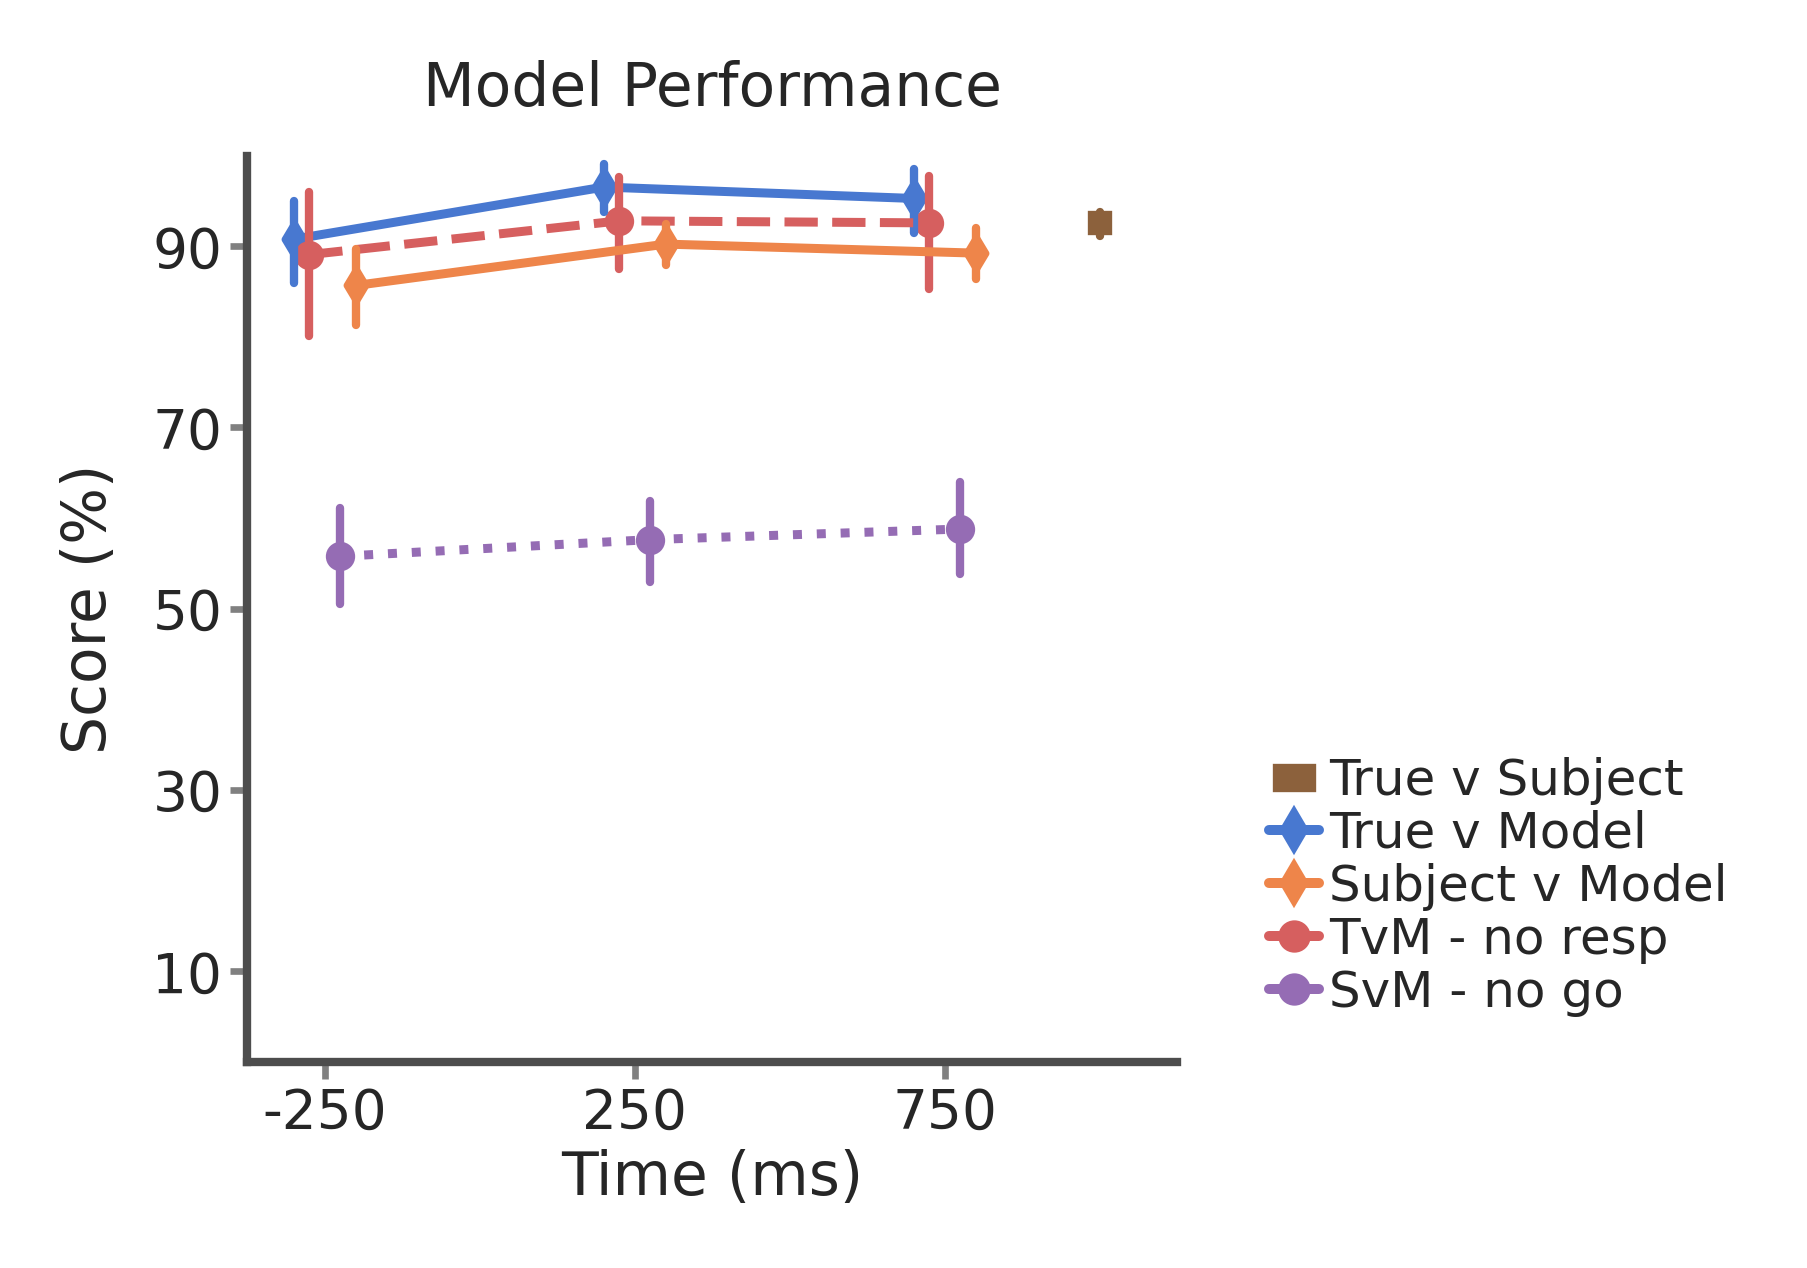

In [193]:
sns.set_theme(context='paper', style="white", font_scale=0.75, palette="Set2")
sns.set_style(rc={"axes.edgecolor":'0.3',
                 'xtick.bottom': True,
                 'ytick.left': True})

point_scale = 0.5
session_lw = 0.5
session_eb = 1
legend_font = 6
s_loc = 2.5
legend_params = dict(handlelength = 1, handletextpad=0.2, bbox_to_anchor=[1.05,0], loc='lower left',
          frameon=False, fontsize=legend_font, markerscale=0.6, labelspacing=0.1)

f,axes=plt.subplots(figsize=(2,2), dpi=600)

ax=axes

split_order = ['test', 'nogo', 'noresp']
comparison_select = ['SvM', 'TvM']
region1 = 'visual'
region2 = 'motor'

subset = perf_df_all[(perf_df_all.pert_matrix=='A1') & 
                     (perf_df_all.pert_pct==0) & 
                     (perf_df_all.data_split.isin(split_order)) & 
                     (perf_df_all.comparison.isin(comparison_select)) & 
                     (perf_df_all.region1==region1) &
                     (perf_df_all.region2==region2)]

subset = subset.groupby(["session_num", "comparison", "data_split", "time_bin"], dropna=True).mean()
subset = subset.drop(['pert_pct'],axis=1)
subset = subset.reset_index()
subset = subset.copy()

subset.loc[ (subset.data_split=='nogo') & (subset.comparison.isin(['TvM', 'TvS'])) ] = np.nan
subset.loc[ (subset.data_split=='noresp') & (subset.comparison.isin(['SvM', 'TvS'])) ] = np.nan
subset = subset.dropna()

# ######
ax.set_ylim([0,1])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9])
ax.set_yticklabels([10, 30 , 50 , 70, 90])

ax.set_xlim([-0.25, s_loc+0.25])
ax.set_xticks([0,1,2])

ax.tick_params(axis='both', which='major', pad=-0.2)
ax.set_title("Model Performance")

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)


ax.tick_params(axis="both", direction="out", length=2, width=0.8, color="0.5",  which='major', pad=1)

################## subject performance#############################
split_order = ['test']
comparison_select = ['TvS']

subset2 = perf_df_all[(perf_df_all.pert_matrix=='A1') & 
                     (perf_df_all.pert_pct==0) & 
                     (perf_df_all.data_split.isin(split_order)) & 
                     (perf_df_all.comparison.isin(comparison_select)) & 
                     (perf_df_all.region1==region1) &
                     (perf_df_all.region2==region2)]

subset2 = subset2.groupby('session_num').mean()
r  = bootstrap( (subset2.score.values,), np.mean, confidence_level=0.95)

ax.scatter(s_loc, subset2.score.mean(), color=colors[5], s=point_scale*20, edgecolor='w', linewidth=0.2, label = 'TvS', marker='s')
ax.plot( (s_loc,s_loc), (r.confidence_interval.low, r.confidence_interval.high), color=colors[5], linewidth=session_eb)

ax.legend().remove()


legend_elements = [Patch(facecolor=colors[5], edgecolor=None, label='True v Subject')]
ax.legend(handles=legend_elements, **legend_params)

ax.set_xticklabels(['-250', '250', '750',])
ax.set_xlabel("Time (ms)", labelpad=1)
ax.set_ylabel(f"Score (%)")
ax.set_xlim([-0.25, s_loc+0.25])

f.savefig( figures_path / f"f1_a" ,bbox_inches='tight')

######################### Model vs #########################################################
sns.set_palette("muted")
colors = sns.color_palette()
sns.pointplot(x='time_bin', y='score', hue='comparison',  data=subset[subset.data_split=='test'], err_style='bars', ax=ax, 
              dodge=0.2, alpha=0.8, legend=True, scale=point_scale, hue_order=['TvM', 'SvM'], errwidth=session_eb, capsize=0, markers=['d', 'd'], palette=colors[:2])

ax.set_xticklabels(['-250', '250', '750',])
ax.set_xlabel("Time (ms)", labelpad=1)
ax.set_ylabel(f"Score (%)")
ax.set_xlim([-0.25, s_loc+0.25])

ax.legend().remove()

legend_elements.append(Line2D([0], [0], marker='d', color=colors[0], label='True v Model'))
legend_elements.append(Line2D([0], [0], marker='d', color=colors[1], label='Subject v Model'))
ax.legend(handles=legend_elements, **legend_params)

f.savefig( figures_path / f"f1_b" ,bbox_inches='tight')

######################### Model vs no resps #########################################################
sns.pointplot(x='time_bin', y='score', hue='comparison',  data=subset[subset.data_split!='test'], err_style='bars', ax=ax, 
              dodge=0.1, alpha=0.8, legend=False, scale=point_scale,  hue_order=['TvM', 'SvM'], errwidth=session_eb, capsize=0, linestyles=["--", ":"], palette=colors[3:])


ax.set_xticklabels(['-250', '250', '750',])
ax.set_xlabel("Time (ms)", labelpad=1)
ax.set_ylabel(f"Score (%)")
ax.set_xlim([-0.25, s_loc+0.25])

ax.legend().remove()

legend_elements.append(Line2D([0], [0], marker='o', color=colors[3], label='TvM - no resp'))
legend_elements.append(Line2D([0], [0], marker='o', color=colors[4], label='SvM - no go'))
ax.legend(handles=legend_elements, **legend_params)

f.savefig( figures_path / f"f1_c" ,bbox_inches='tight')

In [196]:
subset[subset.data_split!='test'].groupby('data_split').mean()

,session_num,time_bin,score
data_split,,,
nogo,6.5,1.0,0.573981
noresp,6.5,1.0,0.914889


## scond figure step by step

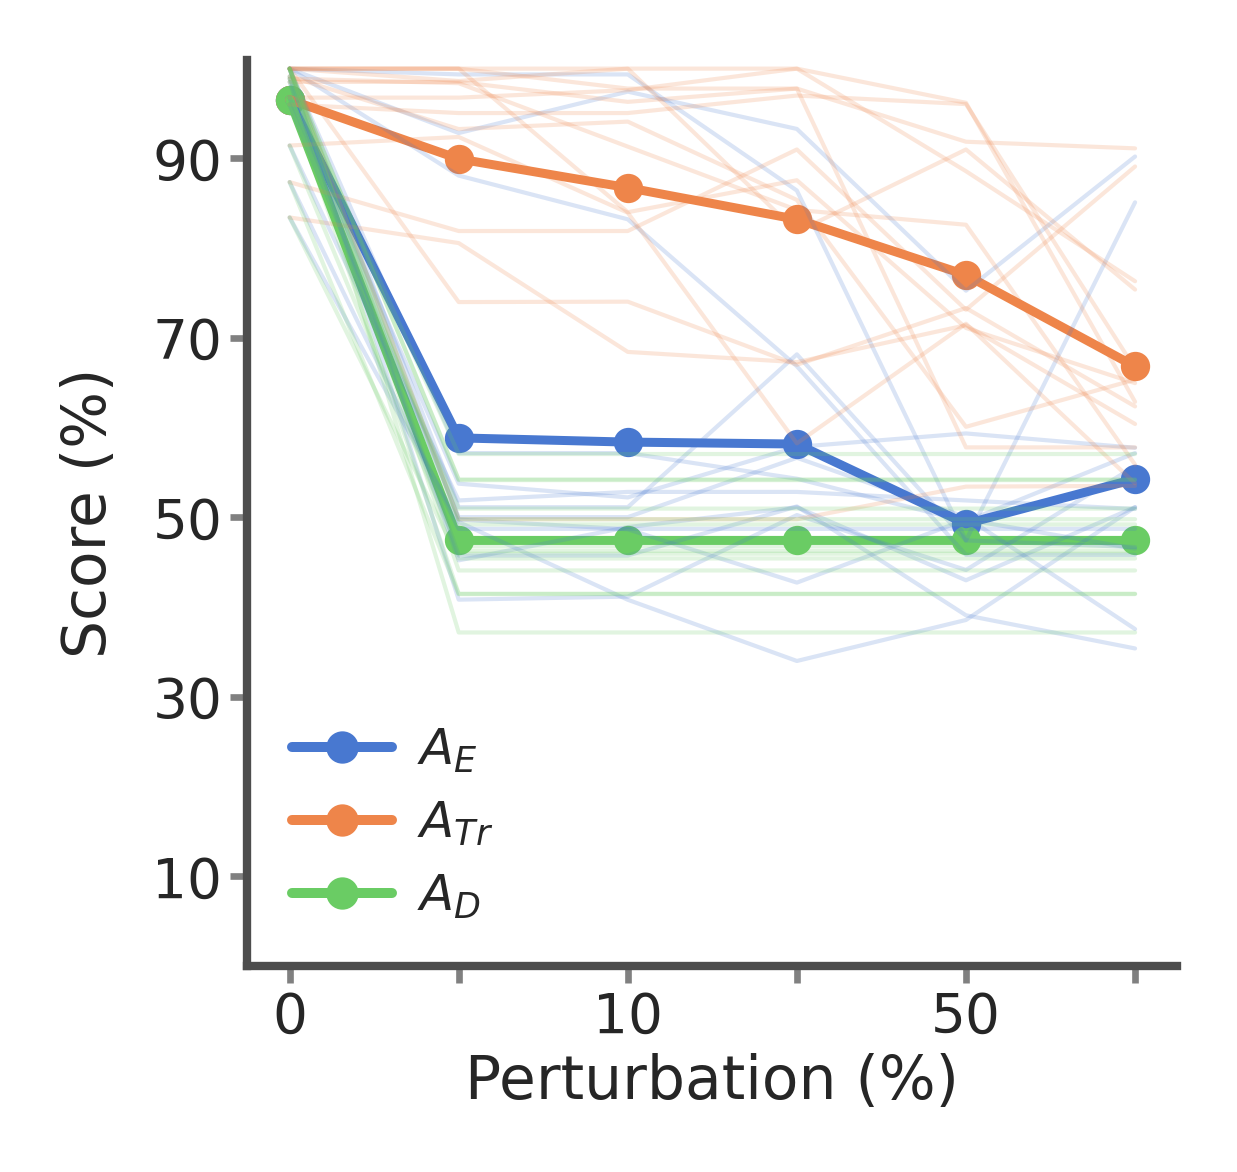

In [192]:
f,axes=plt.subplots(figsize=(2,2), dpi=600)
ax = axes

time_bin = 1
comp = 'TvM'
split='test'
legend_params =  dict(bbox_to_anchor=(0, 0), 
                      handletextpad=0.5, loc='lower left', frameon=False, 
                      fontsize=legend_font, markerscale=0.6, labelspacing=0.5)

y_axis_label = {'TvM': "True v Model", "SvM": "Subject v Model" }

subset = perf_df_all[(perf_df_all.data_split==split) & 
                     (perf_df_all.comparison==comp) & 
                     (perf_df_all.time_bin==time_bin) &
                     (perf_df_all.region1==region1) &
                     (perf_df_all.region2==region2)]
subset = subset.groupby(["session_num", "pert_pct", "pert_matrix"]).mean()
subset = subset.reset_index()
subset = subset.astype({'pert_pct': str})


ax.tick_params(axis='both', which='major', pad=-0.2)
ax.tick_params(axis="both", direction="out", length=2, width=0.8, color="0.5",  which='major', pad=1)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

legend_elements = []
mat_names = [r'$A_E$', r'$A_{Tr}$', r'$A_D$']
sub_figs = ['a','b','c']
cnt = 0
for m in ['A1','A2','A3']:
    ax = sns.pointplot(x='pert_pct', y='score', hue='pert_matrix',err_style='bars', data=subset[subset.pert_matrix==m], ci=None, legend=False, dodge=True, ax=ax, scale=point_scale, palette=colors[cnt:])
    sns.lineplot(x='pert_pct', y='score', units='session_num', estimator=None,data=subset[subset.pert_matrix==m], alpha=0.2, ax=ax, legend=False, linewidth=session_lw, color=colors[cnt])

    
    legend_elements.append(Line2D([0], [0], marker='o', color=colors[cnt], label=mat_names[cnt] ))

    ax.legend(handles=legend_elements, **legend_params)

    ax.set_xlabel("Perturbation (%)", labelpad=1)
    ax.set_xticklabels([0,'',10, '',50,''])

    ax.set_ylim([0,1.01])
    ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9])
    ax.set_yticklabels([10, 30 , 50 , 70, 90])
    ax.set_ylabel(f"Score (%)")

    f.savefig( figures_path / f"f2_{sub_figs[cnt]}" ,bbox_inches='tight')

    cnt+=1
